$$
G(u, v) = \frac{H^*(u, v)}{|H(u, v)|^2 + \frac{S_{\eta}(u, v)}{S_f(u, v)}} F(u, v)
$$

### 参数解释

- $G(u, v)$: 滤波后图像的频域表示。
- $H(u, v)$: 图像退化函数的频域表示（通常为模糊函数）。
- $H^*(u, v)$: $H(u, v)$ 的共轭复数。
- $F(u, v)$: 原始图像的频域表示。
- $S_{\eta}(u, v)$: 噪声的功率谱密度。
- $S_f(u, v)$: 原始图像的功率谱密度。
- $|H(u, v)|^2$: 退化函数的幅值平方。

In [18]:
% 添加目录
addpath('./codes');
addpath('./data');

%% 处理数据
% 加载数据
data = load('data/img_restoration.mat');


In [19]:
% 参数设置
gaussian_size = 5;        % 高斯核大小
gaussian_sigma = 5;       % 高斯噪声标准差
motion_len = 20;          % 运动模糊长度
motion_theta = 60;        % 运动模糊角度

% 原始图像
I1 = data.I1;  
I2 = data.I2;
% I1 = I1 / 255;
% I2 = I2 / 255;

% 创建运动模糊核
h_motion = fspecial('motion', motion_len, motion_theta);

% 应用运动模糊 
motion_I1 = imfilter(I1, h_motion, 'conv', 'same', 'circular'); % 只有运动模糊
motion_I2 = imfilter(I2, h_motion, 'conv', 'same', 'circular');

% 添加加性高斯噪声
noise_sigma = 5; % 设置噪声强度
noise_I1 = randn(size(motion_I1)) * noise_sigma;
noise_I2 = randn(size(motion_I2)) * noise_sigma;

% 高斯噪声图片
gaussian_I1 = I1 + noise_I1;
gaussian_I2 = I2 + noise_I2;

% 高斯加运动模糊图片
noisy_motion_I1 = motion_I1 + noise_I1;     % 运动模糊+高斯噪声
noisy_motion_I2 = motion_I2 + noise_I2;

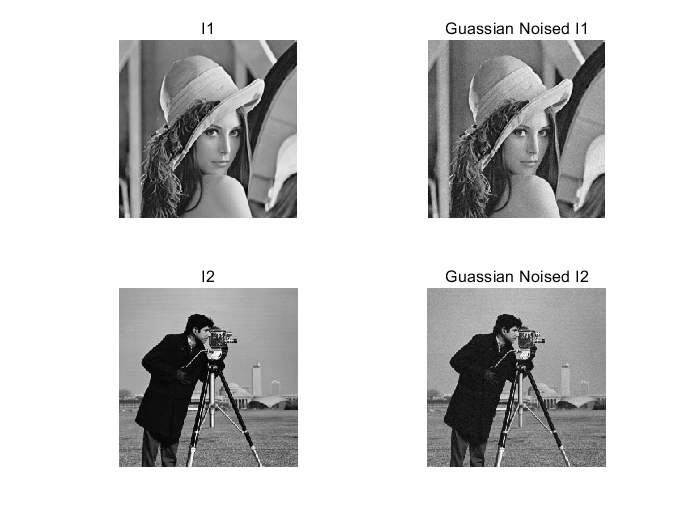

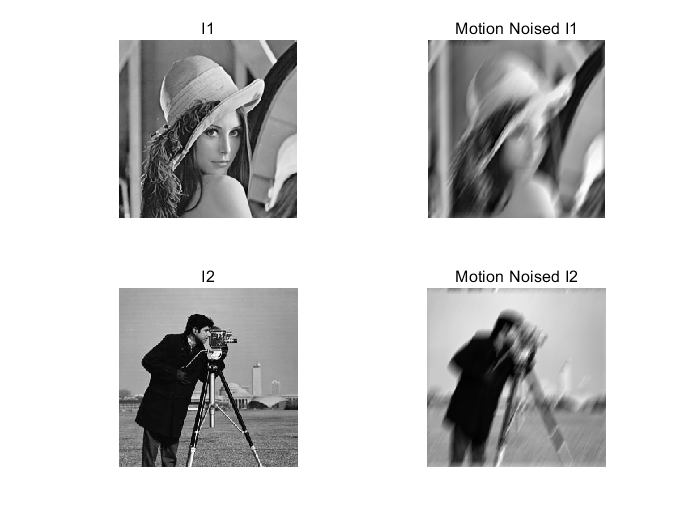

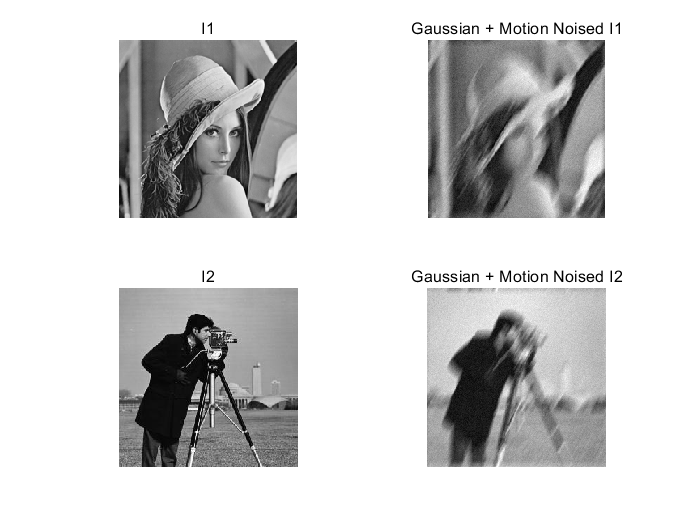

In [20]:

% 显示原图和加高斯噪声后的图像
figure;
subplot(2,2,1), imshow(I1, []), title('I1');
subplot(2,2,2), imshow(gaussian_I1, []), title('Guassian Noised I1');
subplot(2,2,3), imshow(I2, []), title('I2');
subplot(2,2,4), imshow(gaussian_I2, []), title('Guassian Noised I2');

% 显示原图和加运动模糊图像
figure;
subplot(2,2,1), imshow(I1, []), title('I1');
subplot(2,2,2), imshow(motion_I1, []), title('Motion Noised I1');
subplot(2,2,3), imshow(I2, []), title('I2');
subplot(2,2,4), imshow(motion_I2, []), title('Motion Noised I2');

% 显示原图和加高斯加运动模糊图像
figure;
subplot(2,2,1), imshow(I1, []), title('I1');
subplot(2,2,2), imshow(noisy_motion_I1, []), title('Gaussian + Motion Noised I1');
subplot(2,2,3), imshow(I2, []), title('I2');
subplot(2,2,4), imshow(noisy_motion_I2, []), title('Gaussian + Motion Noised I2');

$$
G(u, v) = \frac{H^*(u, v)}{|H(u, v)|^2 + \frac{S_{\eta}(u, v)}{S_f(u, v)}} F(u, v)
$$

### 参数解释

- $G(u, v)$: 滤波后图像。
- $H(u, v)$: 高斯模糊。
- $F(u, v)$: 原始图像的频域表示。
- $S_{n}(u, v)$: 噪声的功率谱密度。
- $S_f(u, v)$: 原始图像的功率谱密度。


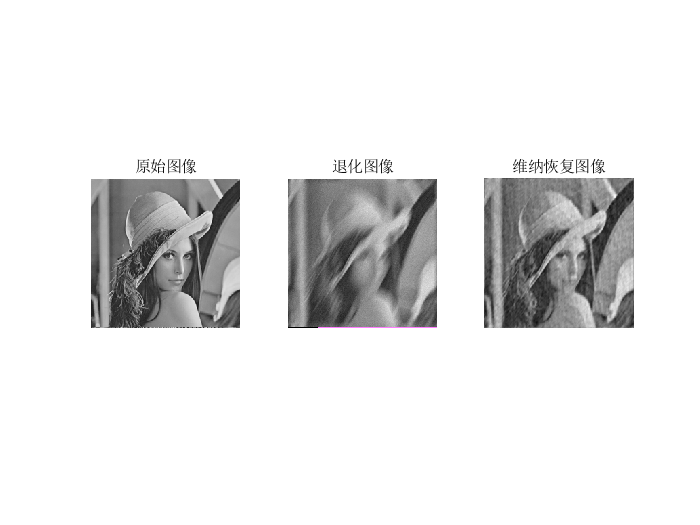

In [21]:
%% 维纳滤波
restore_img = wiener_filter(noisy_motion_I1, I1, noise_I1, h_motion);

% 显示结果
figure;
subplot(1, 3, 1); imshow(uint8(I1)); title('原始图像');
subplot(1, 3, 2); imshow(uint8(noisy_motion_I1)); title('退化图像');
subplot(1, 3, 3); imshow(uint8(restore_img)); title('维纳恢复图像');

### 公式：
$$
\hat{F}(u,v) = \frac{G(u,v)}{H(u,v)}
$$

其中：
- $\hat{F}(u,v)$：恢复后的图像的频谱（频域表示）。
- $G(u,v)$：退化的图像的频谱（带有噪声和模糊）。
- $H(u,v)$：运动模糊核（点扩散函数，PSF）的频域表示（光学传递函数 OTF）。


- 缺点：如果 $H(u,v) $ 在某些频率上接近零，直接逆滤波会导致除零问题，放大噪声，导致严重的恢复不稳定性。

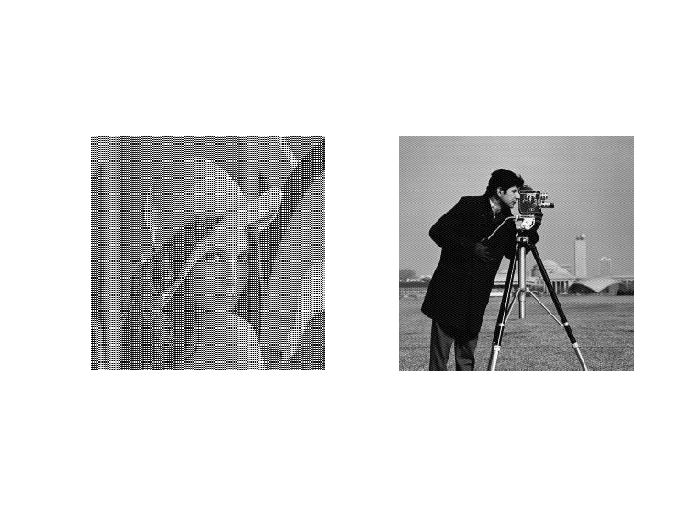

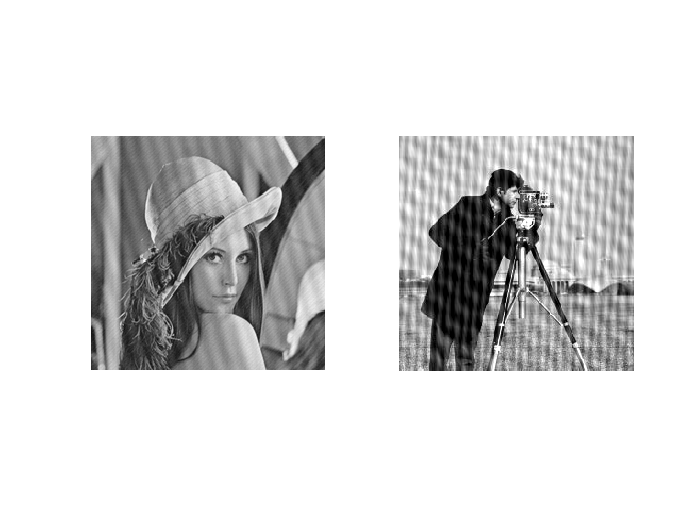

In [22]:
%% 直接逆滤波
% 直接逆滤波存在很多问题，在某些特定角度没办法完成滤波会导致画面崩坏
res_I1 = inverse_filter(h_motion, motion_I1 / 255);
res_I2 = inverse_filter(h_motion, motion_I2 / 255);
figure;
subplot(1, 2, 1), imshow(res_I1);
subplot(1, 2, 2), imshow(res_I2);

res_I1 = inverse_filter(h_motion, motion_I1 / 255, 0.9);
res_I2 = inverse_filter(h_motion, motion_I2 / 255, 0.6);
figure;
subplot(1, 2, 1), imshow(res_I1);
subplot(1, 2, 2), imshow(res_I2);

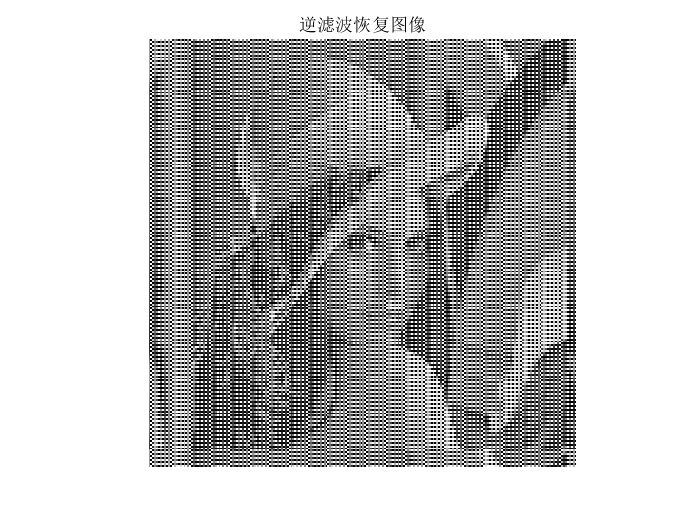

In [23]:
% 逆滤波恢复
G = fft2(motion_I1 / 255);
[M, N] = size(motion_I1);   % 获取图像的尺寸
H = fft2(h_motion, M, N);

F = G ./ H;
f = real(ifft2(F));
figure;
imshow(f);
title("逆滤波恢复图像");

### 公式：
$$
\hat{F}(u,v) = \frac{H^*(u,v) \cdot G(u,v)}{|H(u,v)|^2 + \lambda}
$$

其中：
- $\hat{F}(u,v)$：恢复后的图像的频谱（频域表示）。
- $G(u,v)$：退化的图像的频谱（带有噪声和模糊）。
- $H(u,v)$：运动模糊核（点扩散函数，PSF）的频域表示（光学传递函数 OTF）。
- $\lambda$：正则化参数，用于避免除以零或接近零的频率分量。

- 更稳定，尤其是在有噪声的情况下。
- 可以通过调整 $ \lambda $ 来控制恢复的平滑程度和噪声的抑制效果。
- 需要选择合适的正则化参数 $ \lambda $，否则可能会导致恢复结果过于平滑。

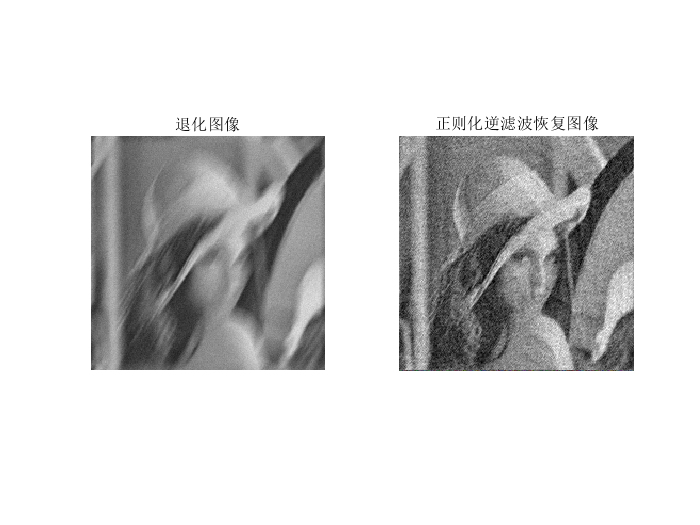

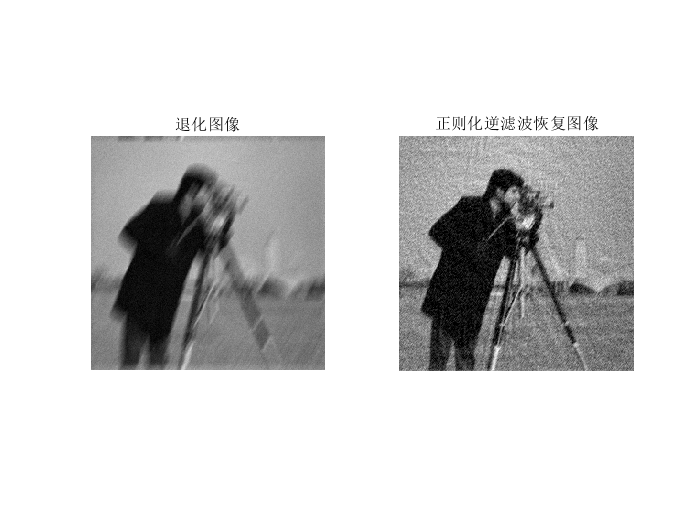

In [24]:
%% 正则化逆滤波
regularized_inverse_filter(h_motion, noisy_motion_I1);
regularized_inverse_filter(h_motion, noisy_motion_I2);

### 时域维纳滤波

图像退化模型：

$$
g(x, y) = f(x, y) \ast h(x, y) + \eta(x, y)
$$

滤波器公式（最小化均方误差的维纳滤波器）：

$$
\hat{f}(x, y) = \frac{S_f(x, y)}{S_f(x, y) + S_{\eta}(x, y)} \cdot g(x, y)
$$

### 参数解释

- $\hat{f}(x, y)$: 滤波后恢复的图像。
- $g(x, y)$: 退化后的输入图像。
- $S_f(x, y)$: 原始图像的自相关函数或功率谱密度。
- $S_{\eta}(x, y)$: 噪声的自相关函数或功率谱密度。
- $f(x, y)$: 原始（未退化）图像。
- $h(x, y)$: 退化函数（如模糊核）。
- $\eta(x, y)$: 噪声。
- $\ast$: 表示卷积操作。